# Optimización y generalización

Pyhton notebook based on: Programming assignment 3 from Hinton's Neural Networks course from coursera

https://www.coursera.org/learn/neural-networks

In [1]:
import scipy.io as sio
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import draw_nn
import importlib

In [2]:
data = sio.loadmat('digits.mat')
training_inputs = data['data']['training'][0][0][0]['inputs'][0]
training_targets = data['data']['training'][0][0][0]['targets'][0]
validation_inputs = data['data']['validation'][0][0][0]['inputs'][0]
validation_targets = data['data']['validation'][0][0][0]['targets'][0]
test_inputs = data['data']['test'][0][0][0]['inputs'][0]
test_targets = data['data']['test'][0][0][0]['targets'][0]

In [3]:
def plot_number(dataset, indexes, figsize=(10, 5)):
    delta = 100
    #
    f, (ax_arr) = plt.subplots(4,int(len(indexes)/4), sharex=False, sharey=False, figsize=figsize)
    ax_arr = ax_arr.flatten()
    for i, index in enumerate(indexes):
        ax_arr[i].imshow(dataset[:,index+delta].reshape(16,16), cmap='gray')

In [4]:
def plot_numbers(dataset, index = 100, columns = 10, rows = 10):
    numbers_rows = []
    for j in range(rows):
        numbers = []
        for i in range(columns):
            numbers.append(dataset[:,index+i+j*columns].reshape(16,16))
        numbers_rows.append(np.concatenate(numbers, axis = 1))
    plt.figure(figsize=(20,10))
    plt.imshow(np.concatenate(numbers_rows, axis = 0), cmap='gray')
    plt.show()
    
def plot_list_numbers(dataset, list_of_numbers, columns = 10, figsize=(20,10)):
    rows = int(np.ceil(len(list_of_numbers)/columns))
    padding = columns*rows - len(list_of_numbers)
    for i in range(padding):
        list_of_numbers.append(-1)
    list_of_numbers = np.array(list_of_numbers).reshape((rows,columns))
    numbers_rows = []
    zero_image = np.zeros((16,16))
    for j in range(rows):
        numbers = []
        for i in range(columns):
            if list_of_numbers[j,i]==-1:
                numbers.append(zero_image)
            else:
                numbers.append(dataset[:,list_of_numbers[j,i]].reshape(16,16))
        numbers_rows.append(np.concatenate(numbers, axis = 1))
    plt.figure(figsize = figsize)
    plt.imshow(np.concatenate(numbers_rows, axis = 0), cmap='gray')
    plt.show()

# Dataset
### Normalized handwritten digits: 
Automatically scanned from envelopes by the U.S. Postal Service. 

The original scanned digits are binary and of different sizes and orientations 

The images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990)

# One-hot encoding

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


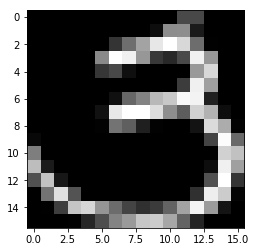

In [5]:
number = 3
print(training_targets[:,number])
plt.imshow(training_inputs[:,number].reshape(16,16), cmap='gray')
plt.show()

# Training set

Cantidad de muestras: 1000


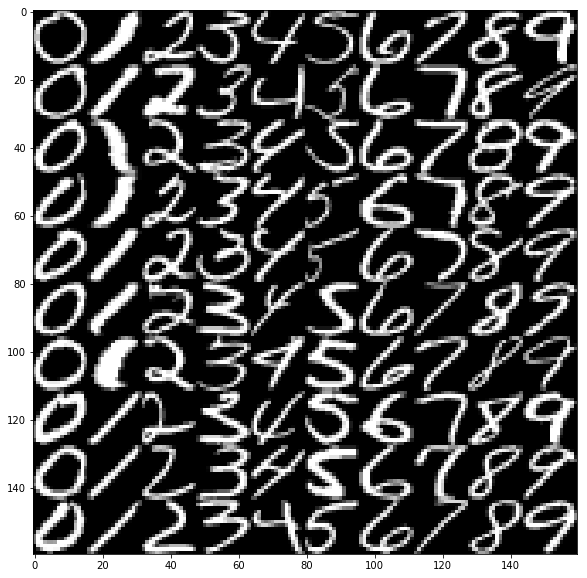

In [6]:
print("Cantidad de muestras:", training_inputs.shape[1])
plot_numbers(training_inputs)

# Cross Validation set

Cantidad de muestras: 1000


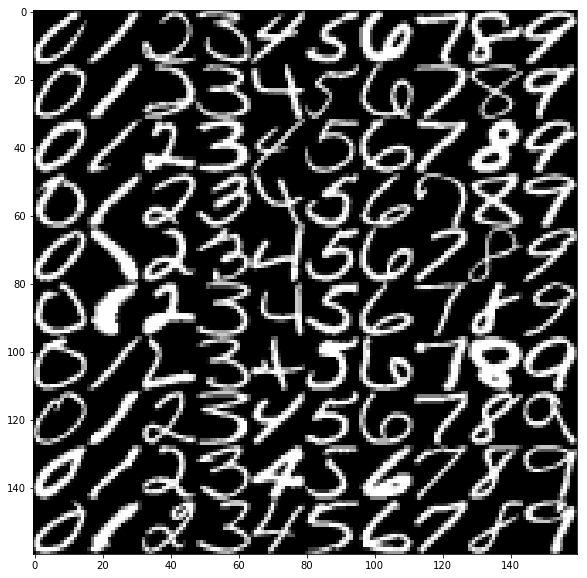

In [7]:
print("Cantidad de muestras:", validation_inputs.shape[1])
plot_numbers(validation_inputs)

# Testing set

Cantidad de muestras: 9000


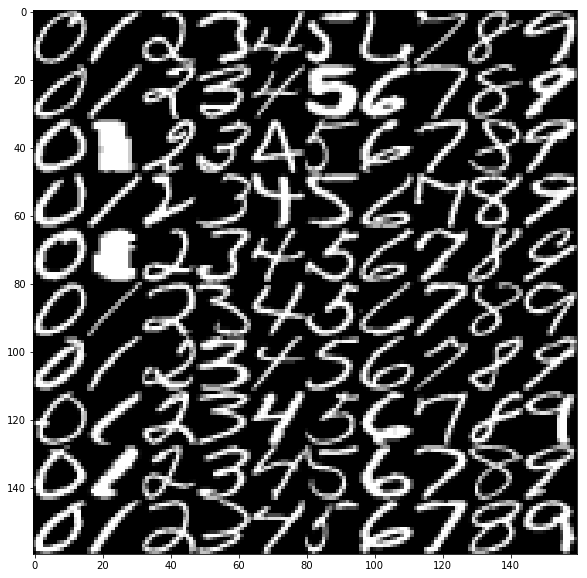

In [8]:
print("Cantidad de muestras:", test_inputs.shape[1])
plot_numbers(test_inputs)

# Red Neuronal 

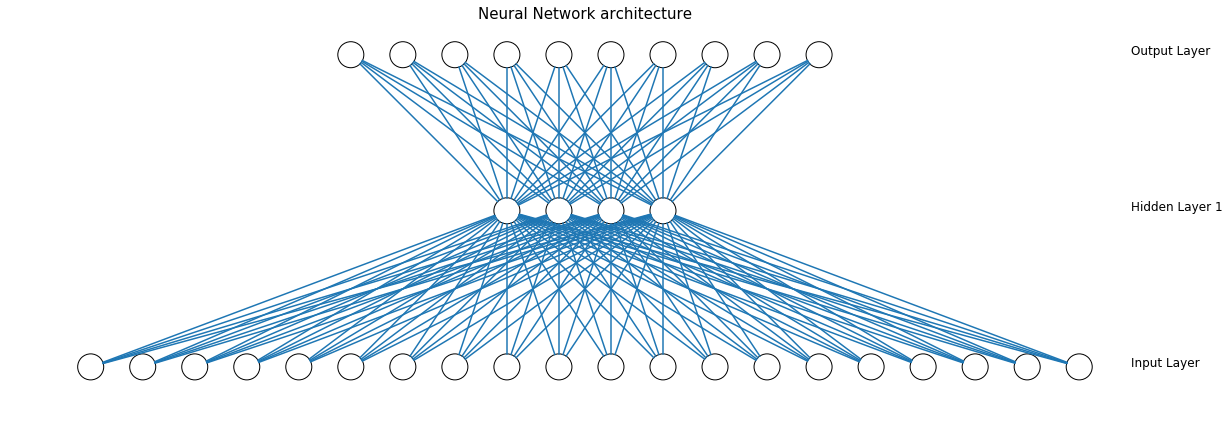

In [9]:
network = draw_nn.DrawNN( [20,4,10] )
network.draw()

#### Input layer: 
- 16x16 pixels = 256 entradas (simplificado a 20 en el diagrama) 
- Escala de grises (floats entre 0 y 1)

#### Hidden layer: 
- Numero variable (Logistic units)

#### Output layer: 
- 10-way softmax

#### Sin biases

In [10]:
n_input = 256
n_output = 10
def model_to_theta(model):
    return np.concatenate((model[0].T.flatten(), model[1].T.flatten()))

def theta_to_model(theta):
    n_hid = int(len(theta) / (n_input+n_output))
    input_to_hid = theta[:n_input*n_hid].reshape(n_input,n_hid).T
    hid_to_class = theta[n_input*n_hid:].reshape(n_hid, n_output).T
    return input_to_hid, hid_to_class
    
def initial_model(n_hid):
    # n_hid: number of hidden logistic units
    n_params = (n_input+n_output) * n_hid
    # No initialized ramdomly to get always the same result
    as_row_vector = np.cos(range(0,(n_params)))* 0.1
    return theta_to_model(as_row_vector)

In [11]:
def logistic(x):
    return 1/(1 + np.exp(-x))

def log_sum_exp_over_rows(a):
    maxs_small = a.max(axis=0)
    maxs_big = np.tile(maxs_small, (a.shape[0], 1));
    return np.log(np.exp(a - maxs_big).sum(axis = 0)) + maxs_small

def loss(model, data_input, data_targets, wd_coefficient):
    # model.input_to_hid is a matrix of size <number of hidden units> by <number of inputs i.e. 256>. It contains the weights from the input units to the hidden units.
    # model.hid_to_class is a matrix of size <number of classes i.e. 10> by <number of hidden units>. It contains the weights from the hidden units to the softmax units.
    # data.inputs is a matrix of size <number of inputs i.e. 256> by <number of data cases>. Each column describes a different data case. 
    # data.targets is a matrix of size <number of classes i.e. 10> by <number of data cases>. Each column describes a different data case. It contains a one-of-N encoding of the class, i.e. one element in every column is 1 and the others are 0.
 
    # Before we can calculate the loss, we need to calculate a variety of intermediate values, like the state of the hidden units.
    hid_input = model[0].dot(data_input) # input to the hidden units, i.e. before the logistic. size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input); # output of the hidden units, i.e. after the logistic. size: <number of hidden units> by <number of data cases>
    class_input =  model[1].dot(hid_output) # input to the components of the softmax. size: <number of classes, i.e. 10> by <number of data cases>
  
    # The following three lines of code implement the softmax.
    # However, it's written differently from what the lectures say.
    # In the lectures, a softmax is described using an exponential divided by a sum of exponentials.
    # What we do here is exactly equivalent (you can check the math or just check it in practice), but this is more numerically stable. 
    # "Numerically stable" means that this way, there will never be really big numbers involved.
    # The exponential in the lectures can lead to really big numbers, which are fine in mathematical equations, but can lead to all sorts of problems in Octave.
    # Octave isn't well prepared to deal with really large numbers, like the number 10 to the power 1000. Computations with such numbers get unstable, so we avoid them.
    class_normalizer = log_sum_exp_over_rows(class_input) # log(sum(exp of class_input)) is what we subtract to get properly normalized log class probabilities. size: <1> by <number of data cases>
    log_class_prob = class_input - np.tile(class_normalizer, (class_input.shape[0], 1)) # log of probability of each class. size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob) # probability of each class. Each column (i.e. each case) sums to 1. size: <number of classes, i.e. 10> by <number of data cases>
  
    classification_loss = -np.mean((log_class_prob*data_targets).sum(axis = 0)) # select the right log class probability using that sum; then take the mean over all data cases.
    wd_loss = sum(model_to_theta(model)**2)/2*wd_coefficient # weight decay loss. very straightforward: E = 1/2 * wd_coeffecient * theta^2
    return classification_loss + wd_loss

In [12]:
def d_loss_by_d_model(model, data_input, data_targets, wd_coefficient):
    # model.input_to_hid is a matrix of size <number of hidden units> by <number of inputs i.e. 256>
    # model.hid_to_class is a matrix of size <number of classes i.e. 10> by <number of hidden units>
    # data.inputs is a matrix of size <number of inputs i.e. 256> by <number of data cases>. Each column describes a different data case. 
    # data.targets is a matrix of size <number of classes i.e. 10> by <number of data cases>. Each column describes a different data case. It contains a one-of-N encoding of the class, i.e. one element in every column is 1 and the others are 0.

    # The returned object is supposed to be exactly like parameter <model>, i.e. it has fields ret.input_to_hid and ret.hid_to_class. However, the contents of those matrices are gradients (d loss by d model parameter), instead of model parameters.

    # This is the only function that you're expected to change. Right now, it just returns a lot of zeros, which is obviously not the correct output. Your job is to replace that by a correct computation.

    N = data_input.shape[1]
    theta = model_to_theta(model);
    gradient_weight = theta*wd_coefficient;

    hid_input = model[0].dot(data_input) # input to the hidden units, i.e. before the logistic. size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input) # output of the hidden units, i.e. after the logistic. size: <number of hidden units> by <number of data cases>
    class_input = model[1].dot(hid_output) # input to the components of the softmax. size: <number of classes, i.e. 10> by <number of data cases>
    class_normalizer = log_sum_exp_over_rows(class_input) # log(sum(exp of class_input)) is what we subtract to get properly normalized log class probabilities. size: <1> by <number of data cases>
   
    log_class_prob = class_input - np.tile(class_normalizer, (class_input.shape[0], 1)) # log of probability of each class. size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob) # probability of each class. Each column (i.e. each case) sums to 1. size: <number of classes, i.e. 10> by <number of data cases>
    
    gradient_class_input_to_hidden = ((model[1].T.dot(class_prob - data_targets))*(hid_output*(1-hid_output))).dot(data_input.T) / N;

    gradient_class_hidden_to_output = (class_prob - data_targets).dot(hid_output.T) / N;

    new_model = theta_to_model(gradient_weight)
    input_to_hid = new_model[0] + gradient_class_input_to_hidden
    hid_to_class = new_model[1] + gradient_class_hidden_to_output
    return input_to_hid, hid_to_class

def classification_performance(model, data_inputs, data_targets):
    # This returns the fraction of data cases that is incorrectly classified by the model.
    hid_input = model[0].dot(data_inputs) # input to the hidden units, i.e. before the logistic. size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input) # output of the hidden units, i.e. after the logistic. size: <number of hidden units> by <number of data cases>
    class_input = model[1].dot(hid_output) # input to the components of the softmax. size: <number of classes, i.e. 10> by <number of data cases>
    choices = np.argmax(class_input, axis=0) # choices is integer: the chosen class, plus 1.
    targets = np.argmax(data_targets, axis=0) # targets is integer: the target class, plus 1.
    return np.mean(choices != targets)

def get_errors(model, data_inputs, data_targets):
    # This returns the fraction of data cases that is incorrectly classified by the model.
    hid_input = model[0].dot(data_inputs) # input to the hidden units, i.e. before the logistic. size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input) # output of the hidden units, i.e. after the logistic. size: <number of hidden units> by <number of data cases>
    class_input = model[1].dot(hid_output) # input to the components of the softmax. size: <number of classes, i.e. 10> by <number of data cases>
    choices = np.argmax(class_input, axis=0) # choices is integer: the chosen class, plus 1.
    targets = np.argmax(data_targets, axis=0) # targets is integer: the target class, plus 1.
    return np.where(choices != targets)

In [13]:
def run_trainig(wd_coefficient = 0, n_hid = 7, n_iters = 0, learning_rate = 0, momentum_multiplier = 0, do_early_stopping = False, mini_batch_size = 0, debug = False):
    n_training_cases = training_inputs.shape[1]
    model = initial_model(n_hid)
    theta = model_to_theta(model)
    momentum_speed = theta * 0
    training_data_losses = []
    validation_data_losses = []
    
    if do_early_stopping:
        best_so_far_theta = -1 # this will be overwritten soon
        best_so_far_validation_loss = float('inf')
        best_so_far_after_n_iters = -1;
    
    for optimization_iteration_i in range(n_iters):
        training_batch_start = (optimization_iteration_i*mini_batch_size)%n_training_cases
        training_batch_inputs = training_inputs[:,training_batch_start:(training_batch_start+mini_batch_size)]
        training_batch_targets = training_targets[:,training_batch_start:(training_batch_start+mini_batch_size)]
        gradient = model_to_theta(d_loss_by_d_model(model, training_batch_inputs, training_batch_targets, wd_coefficient))
        momentum_speed = momentum_speed * momentum_multiplier - gradient
        theta = theta + momentum_speed * learning_rate
        model = theta_to_model(theta);
        training_data_losses.append(loss(model, training_inputs, training_targets, wd_coefficient))
        validation_data_losses.append(loss(model, validation_inputs, validation_targets, wd_coefficient))
        if do_early_stopping:
            if (validation_data_losses[-1] < best_so_far_validation_loss):
                best_so_far_theta = theta; # this will be overwritten soon
                best_so_far_validation_loss = validation_data_losses[-1]
                best_so_far_after_n_iters = optimization_iteration_i
        if (optimization_iteration_i%int(n_iters/10) == 0)&debug:
            print('############################################')
            print('Iteration:',str(optimization_iteration_i),'\ntraining data loss:',str(training_data_losses[-1]),'\nvalidation data loss:', (str(validation_data_losses[-1])));
    
    model = theta_to_model(theta)
    print('SET\t\tLOSS\t\tClassification error')
    print('Training:\t%0.3f'%loss(model, training_inputs, training_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, training_inputs, training_targets))
    print('CV:\t\t%0.3f'%loss(model, validation_inputs, validation_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, validation_inputs, validation_targets))
    print('Tesing:\t\t%0.3f'%loss(model, test_inputs, test_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, test_inputs, test_targets))
    print()
    
    if do_early_stopping:
        theta = best_so_far_theta
        model = theta_to_model(theta)
        print('Early stoping results on iteration:', best_so_far_after_n_iters)
        print('SET\t\tLOSS\t\tClassification error')
        print('Training:\t%0.3f'%loss(model, training_inputs, training_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, training_inputs, training_targets))
        print('CV:\t\t%0.3f'%loss(model, validation_inputs, validation_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, validation_inputs, validation_targets))
        print('Tesing:\t\t%0.3f'%loss(model, test_inputs, test_targets, wd_coefficient),'\t\t%0.3f'%classification_performance(model, test_inputs, test_targets))
        print()
    
    
    plt.figure(figsize = (20,10))
    plt.plot(training_data_losses, label = 'Training')
    plt.plot(validation_data_losses, label = 'Cross Validation')
    plt.legend(loc='best')
    if do_early_stopping:
        plt.scatter(best_so_far_after_n_iters, best_so_far_validation_loss)
    plt.show()
    print('Error list of Trainning:')
    error_list_training = list(get_errors(model, training_inputs, training_targets)[0])[:100]
    if (len(error_list_training)>0):
        plot_list_numbers(training_inputs, error_list_training, columns = 20)
    print('Error list of CV:')
    error_list_validation = list(get_errors(model, validation_inputs, validation_targets)[0])[:100]
    plot_list_numbers(validation_inputs, error_list_validation, columns = 20)
    print('Error list of Test:')
    error_list_test = list(get_errors(model, test_inputs, test_targets)[0])[:100]
    plot_list_numbers(test_inputs, error_list_test, columns = 20)
    return model

SET		LOSS		Classification error
Training:	0.012 		0.000
CV:		0.346 		0.081
Tesing:		0.353 		0.089

Early stoping results on iteration: 133
SET		LOSS		Classification error
Training:	0.096 		0.017
CV:		0.312 		0.092
Tesing:		0.314 		0.091



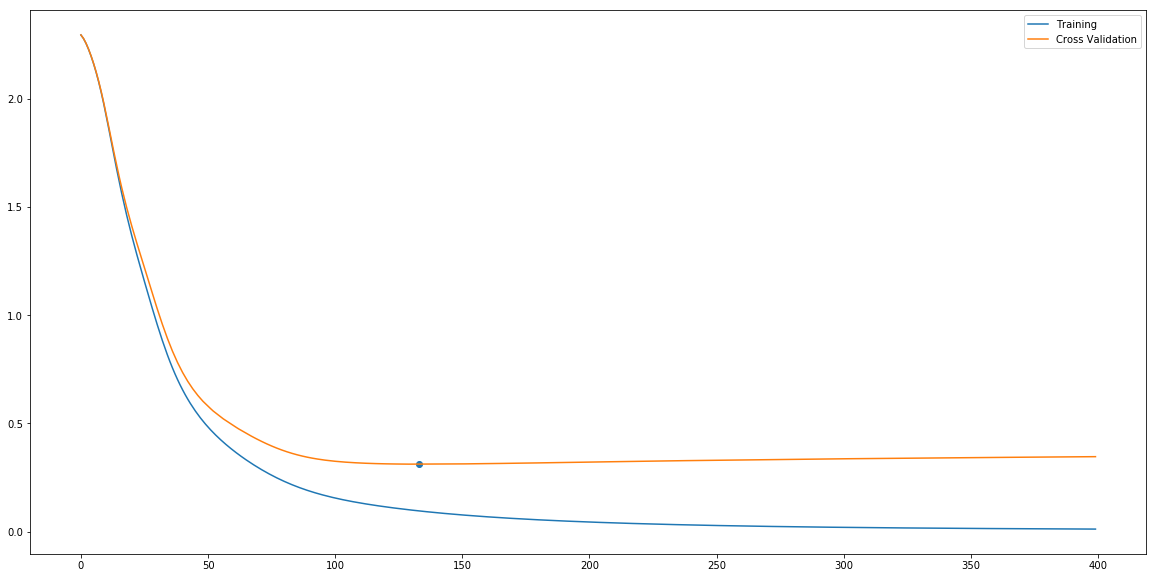

Error list of Trainning:


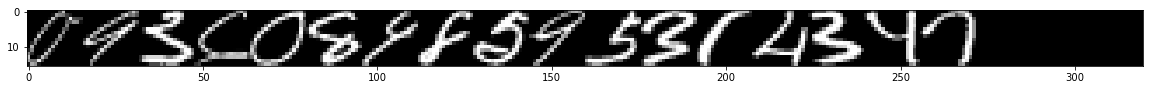

Error list of CV:


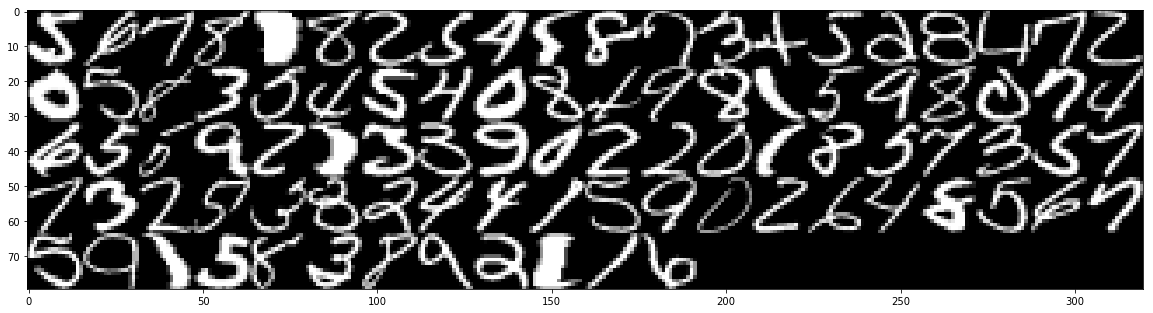

Error list of Test:


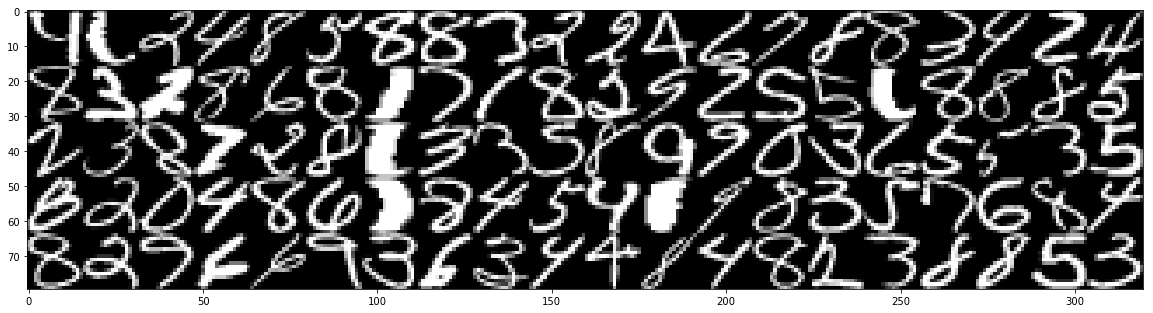

In [14]:
model = run_trainig(debug = False, wd_coefficient = 0, n_hid = 100, n_iters = 400, learning_rate = 0.35, momentum_multiplier = 0.9, do_early_stopping = True, mini_batch_size = 500)